# 0. Installation of the environment

In order to use the environment, you have to install the package gym-foo with **pip install -e gym-foo** were the directory is located (at least on linux).

In [1]:
%load_ext autoreload

%aimport gym
import numpy
import matplotlib.pyplot as plt
env = gym.make('gym_foo:foo-v0', cr = 7, pr = 10, np = 2, ng = 10, alphas = [1,1]) # you can pass the arguments of the __init__ method here

# 1. Principe du jeu

Le jeu possède un nombre fini de manches.

A chaque tour, chaque joueur peut choisir de **coopérer** ou de **se priviliégier**.
Tous les joueurs font leur choix simultanément. Ainsi, aucun joueur ne sait ce que les autres choisissent pendant le tour en cours.

Au début du tour, la cagnotte collective est vide.
Si un joueur **coopère**, il augmente la cagnotte collective de C, mais son **bonus personnel** est nul.
S'il **se privilégie**, la cagnotte collective n'augmente pas, mais son **bonus personnel** vaut P.
C et P sont fixés au début de la partie et sont connus de tous.

La cagnotte collective correspond alors à C mutliplié par le nombre de joueurs ayant coopéré.

A la fin du tour, **chaque** joueur reçoit indépendamment de son choix un montant équivalent à la totalité de la cagnotte collective, plus son bonus personnel. 

$R_i = C\left(\sum_{j=1}^n \mathbb{1}_{a_j=0}\right) + P\mathbb{1}_{a_i=1} = C\left(1+\sum_{j\neq i}^n \mathbb{1}_{a_j=0}\right) + \left(P-C\right)\mathbb{1}_{a_i=1}$ où $R_i$ est le gain du joueur $i$ au dernier tour (donc non pas les gains cumulés), $a_i$ est l'action du joueur $i$ au tour considéré, avec $a_i=1$ s'il se privilégie et $a_i=0$ sinon, et $P > C$


Si C est trop faible (n*C <= P où n est le nombre de joueurs), alors les joueurs n'ont aucun intérêt à coopérer.
Le jeu ne se révèle intéressant que si nC > P.

L'intérêt du jeu porte sur les stratégies adoptées par les joueurs. La meilleure situation pour un joueur est celle où il se privilégie et tous les autres coopèrent. Mais dans ce cas, il perd la confiance des autres joueurs qui peuvent le lui faire payer aux tours suivant en ne coopérant plus. 

Si le jeu ne contient beaucoup de joueurs, on s'attend à voir des comportements différents puisque se venger d'un joueur revient à diminuer le gain de tous.

Voici un exemple de partie à 2 joueurs en trois tours, avec $P = 10$ et $C = 7$ : 
```text
 iter  | p1 | p2
    1  |  0 |  0
rewards| 14 | 14 
    2  |  1 |  0
rewards| 17 |  7
    3  |  1 |  1
rewards| 10 | 10
-----------------
total  | 41 | 31
```

Au premier tous, les deux joueurs ont coopéré, donc la cagnotte collective vaut 2*7 = 14 et aucun ne reçoit de bonus.
Au deuxième tour, seul p2 coopère. La cagnotte collective vaut 7 et p1 reçoit un bonus de 10.
Au troisième tour, aucun joueur ne coopère. La cagnotte collective est nulle et les deux joueurs reçoivent un bonus de 10.

# 1. Basic example 

In [2]:
for i_episode in range(1):
    observation = env.reset()
    for t in range(10):
#         env.render()
#         print(observation)
        action = numpy.random.randint(0,2,env.num_of_players)
        observation, reward, done, info = env.step(action)

        if done:
            env.close()
            break

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 1  
     4| 1  | 1  
     5| 0  | 1  
     6| 0  | 1  
     7| 1  | 0  
     8| 1  | 1  
     9| 0  | 0  
    10| 1  | 1  
scores|110 |130 
 util |110 |130 

p2 has won !


# 2. Test with Q-Learning and tables
We initialize with the reward of a 1-turn game according to the number of cooperating agent and the action the agent has chosen.

We implement a function to enhance the lisibility of the result tables.

In [2]:
def interpretation(table):
    num_of_players = table.shape[1]
    print("num of cooperating players | Q-value if cooperating | Q-value if not")
    for i,line in enumerate(table):
        print("{0:^26} | {1:^22} | {2:^14}".format(i,*line))

## 2.1 $\epsilon$-greedy selection, $\epsilon$ decreasing

In [4]:
tables = [numpy.zeros((env.num_of_players,2)) for player in env.player]
alpha = .9
gamma = .85
epsilon = 0.5
numpy.random.seed(42)
nb_iter = 100000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    
    for t in range(10):
#         env.render()
        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
            
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        for i,player in enumerate(env.player):
            # The only relevant information is the number of agents who chose to cooperate.
            # We simplify the state with the number of cooperating agents.
            # We will update a table in order to find the best action according to the number of cooperating players
            
            coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[i])
            best_action = numpy.argmax(tables[i][coop])
            if 1-epsilon/(i_episode + 1) > numpy.random.uniform():  
                a_t1[i] = best_action
            else:
                a_t1[i] = 1 - best_action

        s_t2, r_t1, done, info = env.step(a_t1)
        for i,player in enumerate(env.player):
            tab = tables[i]
            coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[i]), env.num_of_players - 1 -(sum(s_t2) - s_t2[i])

            tab[coop_t1][a_t1[i]] += alpha * (r_t1[i] + gamma * max(tab[coop_t2]) - tab[coop_t1][a_t1[i]])
        
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [5]:
for player, table in zip(env.player, tables):
    print(player.name)
    interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   63.66666666666671    | 66.66666666666671
            1              |   63.675044854998475   | 66.66666666666671
p2
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   63.66666666666671    | 66.66666666666671
            1              |   63.66666671756393    | 66.66666666666671


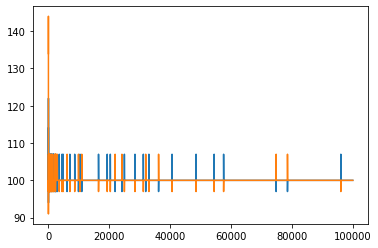

In [6]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
plt.plot(list(range(1,nb_iter + 1)), scores[1,:])

In [7]:
env.reset()

for t in range(10):
#     env.render()
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    for i,player in enumerate(env.player):
        coop = env.num_of_players - 1 - (sum(state) - state[i])
        best_action = numpy.argmax(tables[i][coop])  
        action[i] = best_action
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 1  | 1  
     2| 1  | 1  
     3| 1  | 1  
     4| 1  | 1  
     5| 1  | 1  
     6| 1  | 1  
     7| 1  | 1  
     8| 1  | 1  
     9| 1  | 1  
    10| 1  | 1  
scores|100 |100 
 util |100 |100 

p1 has won !


Both players choose the same strategy, which is never cooperating.

But the scores are not very high. 
We recall that if both were cooperating at each turn, they would both get 140.

## 2.2 Softmax selection 

In [8]:
tables = [numpy.zeros((env.num_of_players,2)) for player in env.player]
for table in tables:
    for i in range(table.shape[1]):
        table[i]=[0,0]

alpha = .9
gamma = .85
tau = 100
numpy.random.seed(42)
nb_iter = 100000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    
    for t in range(10):
#         env.render()
        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
            
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        for i,player in enumerate(env.player):
            # The only relevant information is the number of agents who chose to cooperate.
            # We simplify the state with the number of cooperating agents.
            # We will update a table in order to find the best action according to the number of cooperating players
            
            coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[i])
            p0,p1 = numpy.exp(tables[i][coop,0]/tau),numpy.exp(tables[i][coop,1]/tau)
            if p0/(p0+p1) > numpy.random.uniform():  
                a_t1[i] = 0
            else:
                a_t1[i] = 1

        s_t2, r_t1, done, info = env.step(a_t1)
        for i,player in enumerate(env.player):
            tab = tables[i]
            coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[i]), env.num_of_players - 1 -(sum(s_t2) - s_t2[i])

            tab[coop_t1][a_t1[i]] += alpha * (r_t1[i] + gamma * max(tab[coop_t2]) - tab[coop_t1][a_t1[i]])
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [9]:
for player, table in zip(env.player, tables):
    print(player.name)
    interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |    84.628986330265     | 90.31851037633925
            1              |   87.28870140973734    | 87.27697335905442
p2
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   94.33095143369592    | 97.24496068406769
            1              |   93.46828607745053    | 94.1768786283681


p1 cooperates if the other has cooperated, and choose to play selfish if the other has not cooperated.
p2 always plays selfish.

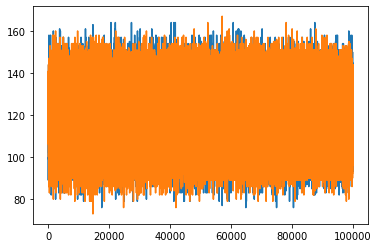

In [10]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
plt.plot(list(range(1,nb_iter + 1)), scores[1,:])

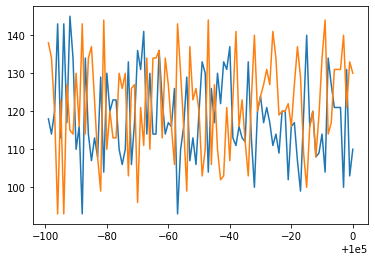

In [11]:
plt.plot(list(range(99901,nb_iter + 1)), scores[0,99900:])
plt.plot(list(range(99901,nb_iter + 1)), scores[1,99900:])

We see that the scores do not converge. It is because both Q-values of an agent are very close, so both actions are almost equiprobable.

In [12]:
env.reset()

for t in range(10):
#     env.render()
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    for i,player in enumerate(env.player):
        coop = env.num_of_players - 1 - (sum(state) - state[i])
        best_action = numpy.argmax(tables[i][coop])  
        action[i] = best_action
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 1  
     2| 1  | 1  
     3| 1  | 1  
     4| 1  | 1  
     5| 1  | 1  
     6| 1  | 1  
     7| 1  | 1  
     8| 1  | 1  
     9| 1  | 1  
    10| 1  | 1  
scores| 97 |107 
 util | 97 |107 

p2 has won !


Here, p2 seems rather dumb. So p1 has the best strategy, whereas p2 has the worst one.

## 2.3 What if p2 has a constant policy ?

A policy giving pretty good results it the following one :
    the agent cooperates until the other one does not. Then, it never cooperates again.

### 2.3.1 $\epsilon$-greedy selection

In [13]:
table = numpy.zeros((env.num_of_players,2))
alpha = .9
gamma = .85
epsilon = 0.5
numpy.random.seed(42)
nb_iter = 10000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    betrayal = False
    
    for t in range(10):

        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
        
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        
        # For the learning agent
        coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[0])
        best_action = numpy.argmax(table[coop])
        if 1-epsilon/(i_episode + 1) > numpy.random.uniform():  
            a_t1[0] = best_action
        else:
            a_t1[0] = 1 - best_action
            
        # For the agent with constant policy
        a_t1[1] = 1*betrayal
        if a_t1[0] == 1:
            betrayal = True

        s_t2, r_t1, done, info = env.step(a_t1)
        
        coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[0]), env.num_of_players - 1 -(sum(s_t2) - s_t2[0])
        table[coop_t1][a_t1[0]] += alpha * (r_t1[0] + gamma * max(table[coop_t2]) - table[coop_t1][a_t1[0]])
        
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [14]:
print("p1")
interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |   63.666666666663616   | 66.6666666666666
            1              |   93.33333333333329    | 69.3662954545454


We see that against an agent having a constant policy, our agent do learn a good strategy.
Yet it is not the best one : it would be better to not cooperate in the last turn, but with that table our agent has no idea which turn it is. 

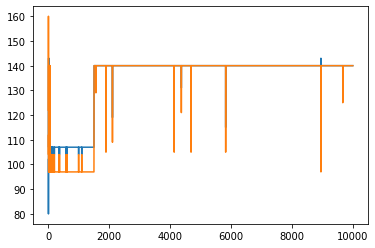

In [15]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
plt.plot(list(range(1,nb_iter + 1)), scores[1,:])

In [16]:
env.reset()
betrayal = False

for t in range(10):
    
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    coop = env.num_of_players - 1 - (sum(state) - state[0])
    best_action = numpy.argmax(table[coop])  
    action[0] = best_action
    action[1] = 1*betrayal
    if action[0] == 1:
        betrayal = True
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 

p1 has won !


### 2.3.2 Softmax-selection

In [17]:
table = numpy.zeros((env.num_of_players,2))
alpha = .9
gamma = .85
tau = 5
numpy.random.seed(42)
nb_iter = 10000
scores = numpy.zeros((env.num_of_players,nb_iter))

for i_episode in range(nb_iter):
    s_t1 = env.reset()
    betrayal = False
    
    for t in range(10):
#         env.render()
        if t == 0:
            s_t1 = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.
            
        a_t1 = numpy.zeros(env.num_of_players, dtype = "int")
        
        # Learning agent
        coop = env.num_of_players - 1 - (sum(s_t1) - s_t1[0])
        p0,p1 = numpy.exp(table[coop,0]/tau),numpy.exp(table[coop,1]/tau)
        if p0/(p0+p1) > numpy.random.uniform():  
            a_t1[0] = 0
        else:
            a_t1[0] = 1
            
        # Other one
        a_t1[1] = 1*betrayal
        
        if a_t1[0] == 1:
            betrayal = True
        
        s_t2, r_t1, done, info = env.step(a_t1)
        coop_t1, coop_t2 = env.num_of_players - 1 - (sum(s_t1) - s_t1[0]), env.num_of_players - 1 -(sum(s_t2) - s_t2[0])

        table[coop_t1][a_t1[0]] += alpha * (r_t1[0] + gamma * max(table[coop_t2]) - table[coop_t1][a_t1[0]])
        s_t1 = s_t2
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [18]:
print("p1")
interpretation(table)

p1
num of cooperating players | Q-value if cooperating | Q-value if not
            0              |          0.0           | 66.6666666666666
            1              |   93.33333333333329    | 69.36362932787895


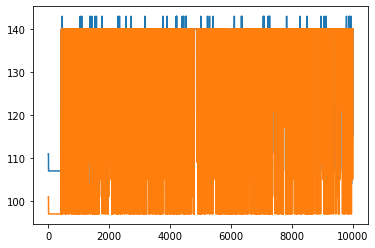

In [19]:
plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
plt.plot(list(range(1,nb_iter + 1)), scores[1,:])

Softmax-selection requires to fine-tune $\tau$. If tau is small enough, our agent learn the best possible behaviour.

In [20]:
env.reset()
betrayal = False

for t in range(10):
    
    if t == 0:
        state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

    action = numpy.zeros(env.num_of_players, dtype = "int")
    coop = env.num_of_players - 1 - (sum(state) - state[0])
    best_action = numpy.argmax(table[coop])  
    action[0] = best_action
    action[1] = 1*betrayal
    if action[0] == 1:
        betrayal = True
    
    state, rewards, done, info = env.step(action)
    
    if done:
        env.close()

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 

p1 has won !


## 2.4 With a bigger table, covering all possibilities (for a game with only 2 players).

In [58]:
observation = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
table = numpy.zeros(2*(p**(env.num_of_games)-1)//(p-1),dtype="int")
alpha = .9
gamma = .85
epsilon = 0.2
numpy.random.seed(42)
nb_iter = 100000
scores = numpy.zeros((env.num_of_players,nb_iter))

action = numpy.zeros(env.num_of_players, dtype = "int")

for i_episode in range(nb_iter):
    state = env.reset()
    betrayal = False
    
    for t in range(env.num_of_games):
        
        # For the learning agent
        case = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
        best_action = numpy.argmax(table[case:case+2])
        if 1-epsilon > numpy.random.uniform():  
            action[0] = best_action
            case += best_action
        else:
            action[0] = 1 - best_action
            case += 1-best_action
            
        # For the agent with constant policy
        action[1] = 1*betrayal
        if action[0] == 1:
            betrayal = True

        state, reward, done, info = env.step(action)
        observation[t,:] = state.copy()
        
        case2 = int(2*(4**(t+1)-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t+1].ravel())]))
        if t < env.num_of_games-1:
            table[case] += alpha * (reward[0] + gamma * max(table[case2:case2+2]) - table[case])
        else:
            table[case] += alpha * reward[0]
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

In [59]:
observation = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
numpy.random.seed(42)

action = numpy.zeros(env.num_of_players, dtype = "int")

state = env.reset()
betrayal = False

for t in range(env.num_of_games):

    # For the learning agent
    case = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
    action[0] = numpy.argmax(table[case:case+2])
    case += action[0]

    # For the agent with constant policy
    action[1] = 1*betrayal
    if action[0] == 1:
        betrayal = True

    state, reward, done, info = env.step(action)
    observation[t,:] = state.copy()

    if done:
        env.render()

 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 



In [ ]:
observation_p1 = numpy.zeros((env.num_of_games,env.num_of_players))
observation_p2 = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
table_p1 = numpy.zeros(2*(p**(env.num_of_games)-1)//(p-1),dtype="int")
table_p2 = numpy.zeros(2*(p**(env.num_of_games)-1)//(p-1),dtype="int")
alpha = .5
gamma = .85
epsilon = 0.2
numpy.random.seed(42)
nb_iter = 1000000
scores = numpy.zeros((env.num_of_players,nb_iter))

action = numpy.zeros(env.num_of_players, dtype = "int")

for i_episode in range(nb_iter):
    state = env.reset()
    if i_episode % (nb_iter//100) == 0:
        print(i_episode//(nb_iter//100))
    
    for t in range(env.num_of_games):
        
        # For p1
        case1_p1 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
        best_action_p1 = numpy.argmax(table[case1_p1:case1_p1+2])
        if 1-epsilon > numpy.random.uniform():  
            action[0] = best_action_p1
            case1_p1 += best_action_p1
        else:
            action[0] = 1 - best_action_p1
            case1_p1 += 1-best_action_p1
            
        # For the agent with constant policy
        case1_p2 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
        best_action_p2 = numpy.argmax(table[case1_p2:case1_p2+2])
        if 1-epsilon > numpy.random.uniform():  
            action[1] = best_action_p2
            case1_p2 += best_action_p2
        else:
            action[1] = 1 - best_action_p2
            case1_p2 += 1-best_action_p2

        state, reward, done, info = env.step(action)
        observation[t,:] = state.copy()
        
        case2_p1 = int(2*(4**(t+1)-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t+1].ravel())]))
        if t < env.num_of_games-1:
            table_p1[case1_p1] = numpy.log(numpy.exp(table_p1[case1_p1]) + alpha * (reward[0] + gamma * max(table_p1[case2_p1:case2_p1+2]) - table_p1[case1_p1]))
        else:
            table_p1[case1_p1] = numpy.log(reward[0])
            
        case2_p2 = int(2*(4**(t+1)-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t+1].ravel())]))
        if t < env.num_of_games-1:
            table_p2[case1_p2] = numpy.log(numpy.exp(table_p2[case1_p2]) + alpha * (reward[1] + gamma * max(table_p2[case2_p2:case2_p2+2]) - table_p1[case1_p2]))
        else:
            table_p2[case1_p2] = numpy.log(reward[1])
            
        if done:
            current_scores = [player.balance for player in env.player]
            for i,player in enumerate(env.player):
                scores[i,i_episode] = player.utility(current_scores[i], current_scores)
            break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [ ]:
observation = numpy.zeros((env.num_of_games,env.num_of_players))
p = 2*env.num_of_players
numpy.random.seed(42)

action = numpy.zeros(env.num_of_players, dtype = "int")

state = env.reset()

for t in range(env.num_of_games):

    # For the learning agent
    case_p1 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
    action[0] = numpy.argmax(table_p1[case_p1:case_p1+2])
    case_p1 += action[0]

    # For the agent with constant policy
    case_p2 = int(2*(4**t-1)//3+2*sum([obs*2**i for i,obs in enumerate(observation[:t].ravel())]))
    action[1] = numpy.argmax(table_p2[case_p2:case_p2+2])
    case_p2 += action[1]

    state, reward, done, info = env.step(action)
    observation[t,:] = state.copy()

    if done:
        env.render()

In [ ]:
table_p2[10100:10200]

# 3. Building an agent with memory : policy-based methods

We could create a table with the iteration to learn a better behaviour against the constant agent. <br>
But let's say we want an agat able to imitate its behaviour : cooperating until the other one betrays, then never again.

With only the iteration added, our agent will not be able to learn it.
We could create a table with every possible policy for the other agent, but its size would be huge. And it would grow exponentially with the number of agents involved.

Let's rather focus directly on the policy. We are going to try to find a good and simple parametrization for the policy.


## 3.1 Parametrization

$\pi_i(t) = \mathbb{1}\{\theta_0+\sum_{j=1}^{t-1}\theta_{j,1} N_j + \theta_{j,2}\} \geq 0$

We have the previous agent with $\theta_0 = -1$, $\forall 1 \leq j \leq 9, \theta_{j,1} = 1$ and $\forall 1 \leq j \leq 9, \theta_{j,2} = 0$ , ie $$\theta = \begin{pmatrix} 1 & 0 \\ 1 & 0 \\ \vdots & \vdots\\ 1 & 0 \end{pmatrix}$$

And we have the agent we want with $$\theta = \begin{pmatrix} 1 & 0 \\ 1 & 0 \\ \vdots & \vdots\\ 1 & 0\\ 1 & 1 \end{pmatrix}$$

In [7]:
def sigma(x):
    return 1/(1+numpy.exp(-x))

In [8]:
theta1 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games-1) + [1]]).T
theta2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games)]).T

In [17]:
def test(theta1 = None, theta2 = None):
    env.reset()
    action = numpy.zeros(env.num_of_players, dtype = "int") 
    N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
    N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])

    for t in range(10):

        if t == 0:
            state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

        action[0] = 1*(.5 <= sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1])))
        action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)
        if t+1 < env.num_of_games:
            N1[t+1], N2[t+1] = action[1], action[0]

        state, rewards, done, info = env.step(action)

        if done:
            env.close()

In [18]:
test(theta1 = theta1, theta2 = theta2)

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 1  | 0  
scores|143 |133 
 util |143 |133 

p1 has won !


## 3.2 Gradient policy

In [33]:
def fit(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True):
    numpy.random.seed(42)

    scores = numpy.zeros((env.num_of_players,nb_iter))
    action = numpy.zeros(env.num_of_players, dtype = "int")

    theta1 = numpy.random.uniform(-2,2,size = 2*env.num_of_games).reshape(env.num_of_games,2)

    for i_episode in range(nb_iter):

        env.reset()
        N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        R = 0

        for t in range(10):              

            # Learning agent
            action[0] = 1*(numpy.random.uniform() < sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1]))) # So we can use what is done in course 7
            action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)

            if t+1 < env.num_of_games:
                N1[t+1],N2[t+1] = action[1],action[0]

            state, reward, done, info = env.step(action)

            # Learning phase
            R += reward[0]-env.num_of_players*env.collective_reward # If we do not substract that, then R is always positive and this method would not be able to converge
            prev_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 += alpha/numpy.sqrt(1+i_episode*decreasing) * R * (1-sigma(theta1[:t+1,0].dot(N1[:t+1])))*numpy.concatenate([N1,[0]+[1]*t+[0]*(env.num_of_games-1-t)]).reshape(2,env.num_of_games).T
            new_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 *= prev_norm/new_norm

            if done:
                current_scores = [player.balance for player in env.player]
                for i,player in enumerate(env.player):
                    scores[i,i_episode] = player.utility(current_scores[i], current_scores)
                break
    return theta1, scores

In [34]:
def fit_test(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True):
    theta1, scores = fit(theta2, nb_iter, alpha, decreasing)
    
    plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
    plt.plot(list(range(1,nb_iter + 1)), scores[1,:])
    plt.show()
    
    test(theta1 = theta1, theta2 = theta2)

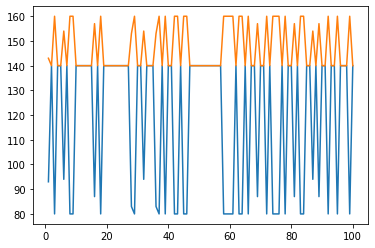

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 

p1 has won !


In [35]:
fit_test(theta2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games)]).T)

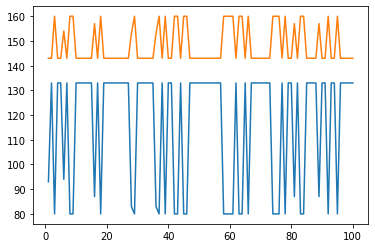

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 1  
scores|133 |143 
 util |133 |143 

p2 has won !


In [36]:
fit_test(theta2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[0]*(env.num_of_games-1)+[1]]).T)

A problem with this method is that here, $\nabla_{\theta}J(\theta)$ has either all its coefficient positive or negative.

Against another opponent ? (e.g. cooperating in the first five turns)

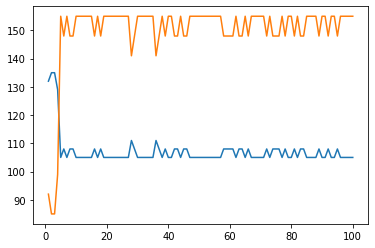

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 1  
     7| 0  | 1  
     8| 0  | 1  
     9| 0  | 1  
    10| 0  | 1  
scores|105 |155 
 util |105 |155 

p2 has won !


In [37]:
fit_test(theta2 = numpy.array([[-1]+[0]*(env.num_of_games-1),[0]*(env.num_of_games//2)+[1]*(env.num_of_games-env.num_of_games//2)]).T)

Let's try to change our parametrization so that $\nabla_{\theta}J(\theta)$ can contain positive and negative values.

From now on, $N'_i = -1$ if every other agent have cooperated and $N'_i = \frac{N_i}{N-1}$ where $N$ is the number of players. We remind the reader that $N_i$ is the number of players who have not cooperated **among** the other players.

In [39]:
def test(theta1 = None, theta2 = None):
    env.reset()
    action = numpy.zeros(env.num_of_players, dtype = "int") 
    N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
    N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])

    for t in range(10):

        if t == 0:
            state = [0 for player in env.player] # We start with the idea that everyone is cooperating. That is a choice.

        action[0] = 1*(.5 <= sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1])))
        action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)
        if t+1 < env.num_of_games:
            N1[t+1] = 2*action[1]-1
            N2[t+1] = 2*action[0]-1
        state, rewards, done, info = env.step(action)

        if done:
            env.close()

In [45]:
policy1 = numpy.array([[-1]+[1]*(env.num_of_games-1),[1]*env.num_of_games]).T
policy2 = numpy.array([[-1]+[1]*(env.num_of_games-1),[1]*(env.num_of_games-1)+[2]]).T

In [46]:
test(policy1,policy2)

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 1  
scores|133 |143 
 util |133 |143 

p2 has won !


In [57]:
def fit(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True):
    numpy.random.seed(42)

    scores = numpy.zeros((env.num_of_players,nb_iter))
    action = numpy.zeros(env.num_of_players, dtype = "int")

    theta1 = numpy.random.uniform(-2,2,size = 2*env.num_of_games).reshape(env.num_of_games,2)

    for i_episode in range(nb_iter):

        env.reset()
        N1 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        N2 = numpy.concatenate([[1],[0]*(env.num_of_games-1)])
        R = 0

        for t in range(10):              

            # Learning agent
            action[0] = 1*(numpy.random.uniform() < sigma(theta1[:t+1,0].dot(N1[:t+1]) + sum(theta1[1:t+1,1]))) # So we can use what is done in course 7
            action[1] = 1*(theta2[:t+1,0].dot(N2[:t+1]) + sum(theta2[1:t+1,1]) >= 0)

            if t+1 < env.num_of_games:
                N1[t+1],N2[t+1] = 2*action[1]-1,2*action[0]-1

            state, reward, done, info = env.step(action)

            # Learning phase
            R += reward[0]-env.num_of_players*env.collective_reward # If we do not substract that, then R is always positive and this method would not be able to converge
            prev_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 += alpha/numpy.sqrt(1+i_episode*decreasing) * R * (1-sigma(theta1[:t+1,0].dot(N1[:t+1])))*numpy.concatenate([N1,[0]+[1]*t+[0]*(env.num_of_games-1-t)]).reshape(2,env.num_of_games).T
            new_norm = numpy.sqrt(numpy.sum(theta1**2))
            theta1 *= prev_norm/new_norm

            if done:
                current_scores = [player.balance for player in env.player]
                for i,player in enumerate(env.player):
                    scores[i,i_episode] = player.utility(current_scores[i], current_scores)
                break
    return theta1, scores

In [58]:
def fit_test(theta2 = None, nb_iter = 100, alpha = 1, decreasing = True, res = False):
    theta1, scores = fit(theta2, nb_iter, alpha, decreasing)
    
    plt.plot(list(range(1,nb_iter + 1)), scores[0,:])
    plt.plot(list(range(1,nb_iter + 1)), scores[1,:])
    plt.show()
    
    test(theta1 = theta1, theta2 = theta2)
    if res:
        return theta1

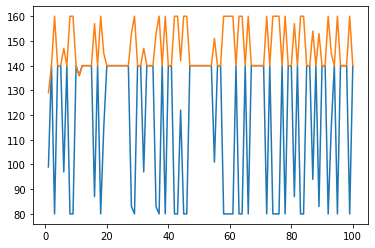

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 0  
scores|140 |140 
 util |140 |140 

p1 has won !


In [59]:
fit_test(policy1)

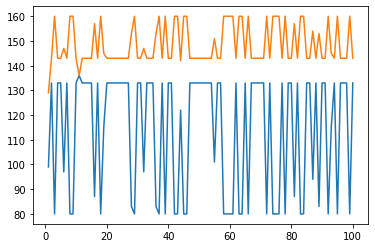

End of the 10 turns.
 iter | p1 | p2 
     1| 0  | 0  
     2| 0  | 0  
     3| 0  | 0  
     4| 0  | 0  
     5| 0  | 0  
     6| 0  | 0  
     7| 0  | 0  
     8| 0  | 0  
     9| 0  | 0  
    10| 0  | 1  
scores|133 |143 
 util |133 |143 

p2 has won !


In [60]:
fit_test(policy2)

It is not better : the gradient is still too uniform.

## 3.3 More complex gradient with tensorflow
*from https://gist.github.com/shanest/535acf4c62ee2a71da498281c2dfc4f4*

In [2]:
import tensorflow as tf      # Deep Learning library

In [260]:
class PolicyGradientAgent(object):

    def __init__(self, hparams, sess):

        # initialization
        self._s = sess

        # build the graph
        self._input = tf.placeholder(tf.float32,
                shape=[None, hparams['input_size']])

        hidden1 = tf.contrib.layers.fully_connected(
                inputs=self._input,
                num_outputs=hparams['hidden_size'],
                activation_fn=tf.nn.relu,
                weights_initializer=tf.random_normal_initializer())
        
        hidden2 = tf.contrib.layers.fully_connected(
                inputs=hidden1,
                num_outputs=hparams['hidden_size'],
                activation_fn=tf.nn.relu,
                weights_initializer=tf.random_normal_initializer())
            
        hidden3= tf.contrib.layers.fully_connected(
                inputs=hidden2,
                num_outputs=hparams['hidden_size'],
                activation_fn=tf.nn.relu,
                weights_initializer=tf.random_normal_initializer())


        logits = tf.contrib.layers.fully_connected(
                inputs=hidden3,
                num_outputs=hparams['num_actions'],
                activation_fn=None)

        # op to sample an action
        self._sample = tf.reshape(tf.multinomial(logits, 1), [])

        # get log probabilities
        log_prob = tf.log(tf.nn.softmax(logits))

        # training part of graph
        self._acts = tf.placeholder(tf.int32)
        self._advantages = tf.placeholder(tf.float32)

        # get log probs of actions from episode
        indices = tf.range(0, tf.shape(log_prob)[0]) * tf.shape(log_prob)[1] + self._acts
        act_prob = tf.gather(tf.reshape(log_prob, [-1]), indices)

        # surrogate loss
        loss = -tf.reduce_sum(tf.multiply(act_prob, self._advantages))

        # update
        optimizer = tf.train.RMSPropOptimizer(hparams['learning_rate'])
        self._train = optimizer.minimize(loss)

    def act(self, observation):
        # get one action, by sampling
        return 1*(self._s.run(self._sample, feed_dict={self._input: [observation]})>0)

    def train_step(self, obs, acts, advantages):
        batch_feed = { self._input: obs, \
                self._acts: acts, \
                self._advantages: advantages }
        self._s.run(self._train, feed_dict=batch_feed)


def policy_rollout(env, agent):
    """Run one episode."""

    env.reset()
    betrayal = False
    action = numpy.zeros(2)
    
    obs = []
    acts = []
    rews = []
    state = numpy.zeros((env.num_of_games,2))
    
    for t in range(env.num_of_games):
        action[0] = agent.act(state.ravel())
        action[1] = 1*betrayal
        
        observation, reward, done, _ = env.step(action)
        
        state[t,:] = 2*action[0]-1, 2*action[1]-1
        if action[0] == 1:
            betrayal = True
        
        obs.append(state.ravel().copy())
        acts.append(action[0])
        rews.append(reward[0])
    return obs, acts, rews


def process_rewards(rews):
    """Rewards -> Advantages for one episode. """

    # total reward: length of episode
    return numpy.cumsum(rews)


def learning(verbose = False):

    # hyper parameters
    hparams = {
            'input_size': 20,
            'hidden_size': 40,
            'num_actions': 2,
            'learning_rate': 0.002
    }

    # environment params
    eparams = {
            'num_batches': 100,
            'ep_per_batch': 10
    }

    with tf.Graph().as_default(), tf.Session() as sess:

        agent = PolicyGradientAgent(hparams, sess)

        sess.run(tf.initialize_all_variables())

        for batch in range(eparams['num_batches']):

            if verbose:
                print('=====\nBATCH {}\n===='.format(batch))
            else:
                print(f"BATCH {batch}")

            b_obs, b_acts, b_rews = [], [], []

            for _ in range(eparams['ep_per_batch']):

                obs, acts, rews = policy_rollout(env, agent)
                
                if verbose:
                    print('Episode steps: {}'.format(len(obs)))

                b_obs.extend(obs)
                b_acts.extend(acts)

                advantages = process_rewards(rews)
                b_rews.extend(advantages)

            # update policy
            # normalize rewards; don't divide by 0
            b_rews = (b_rews - numpy.mean(b_rews)) / (numpy.std(b_rews) + 1e-10)

            agent.train_step(b_obs, b_acts, b_rews)
        env.close()

In [261]:
learning()

BATCH 0
[14.0, 17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[14.0, 17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[14.0, 17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[14.0, 17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[14.0, 17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[14.0, 17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
BATCH 1
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[17.0, 1